In [1]:
import os

import numpy as np
import pandas as pd

In [2]:
labels_file = 'Data/participants.tsv'
data_directory = 'cc_matrices/'

In [3]:
def read_matrix_from_file(file_path):
    with open(file_path, 'r') as file:
        content = file.readlines()
        matrix = []
        for line in content:
            values = line.rstrip().split(',')
            row = []
            for val in values:
                if val.strip():
                    try:
                        row.append(float(val))
                    except ValueError:
                        print(f"Warning: Non-numeric value '{val}' found. Skipping.")
            if row:
                matrix.append(row)
    return np.array(matrix)

In [4]:
participant_data = pd.read_csv(labels_file, sep='\t')
diagnosis_data = participant_data[['participant_id', 'diagnosis']]
unique_labels = ['CONTROL', 'ADHD', 'BIPOLAR', 'SCHZ']

labels_dict = dict(zip(diagnosis_data['participant_id'], diagnosis_data['diagnosis']))
labels_dict = {int(key.replace('sub-', '')): value for key, value in labels_dict.items()}
label_to_number = {label: i for i, label in enumerate(unique_labels)}
numerical_labels_dict = {participant_id: label_to_number[label] for participant_id, label in labels_dict.items()}

print("Unique Labels:", unique_labels)
print("Labels:\n", numerical_labels_dict)

Unique Labels: ['CONTROL', 'ADHD', 'BIPOLAR', 'SCHZ']
Labels:
 {10159: 0, 10171: 0, 10189: 0, 10193: 0, 10206: 0, 10217: 0, 10225: 0, 10227: 0, 10228: 0, 10235: 0, 10249: 0, 10269: 0, 10271: 0, 10273: 0, 10274: 0, 10280: 0, 10290: 0, 10292: 0, 10299: 0, 10304: 0, 10316: 0, 10321: 0, 10325: 0, 10329: 0, 10339: 0, 10340: 0, 10345: 0, 10347: 0, 10356: 0, 10361: 0, 10365: 0, 10376: 0, 10377: 0, 10388: 0, 10428: 0, 10429: 0, 10438: 0, 10440: 0, 10448: 0, 10455: 0, 10460: 0, 10471: 0, 10478: 0, 10487: 0, 10492: 0, 10501: 0, 10506: 0, 10517: 0, 10523: 0, 10524: 0, 10525: 0, 10527: 0, 10530: 0, 10557: 0, 10565: 0, 10570: 0, 10575: 0, 10624: 0, 10629: 0, 10631: 0, 10638: 0, 10668: 0, 10672: 0, 10674: 0, 10678: 0, 10680: 0, 10686: 0, 10692: 0, 10696: 0, 10697: 0, 10704: 0, 10707: 0, 10708: 0, 10719: 0, 10724: 0, 10746: 0, 10762: 0, 10779: 0, 10785: 0, 10788: 0, 10844: 0, 10855: 0, 10871: 0, 10877: 0, 10882: 0, 10891: 0, 10893: 0, 10912: 0, 10934: 0, 10940: 0, 10948: 0, 10949: 0, 10958: 0, 10963:

In [5]:
from collections import Counter

occurrences = Counter(labels_dict.values())
print("Whole dataset")
print(occurrences)

Whole dataset
Counter({'CONTROL': 130, 'SCHZ': 50, 'BIPOLAR': 49, 'ADHD': 43})


In [6]:
def read_data():
    data = []
    target = []
    for filename in os.listdir(data_directory):
        if filename.endswith('.txt'):
            file_id = int(filename.split('-')[-1].split('.')[0])
            if int(file_id) in labels_dict:
                file_path = os.path.join(data_directory, filename)
                matrix = read_matrix_from_file(file_path)
                data.append(matrix)
                label = labels_dict[file_id]
                if label == "CONTROL":
                    target.append(0)
                else:
                    target.append(1)
            else:
                raise Exception(f'{file_id} not in labels_dict')
    return data, target

In [7]:
data, target = read_data()

In [8]:
print("Current dataset")
for idx, d in enumerate(data):
    if len(d) != 117:
        print(f'Deleted file: size:{len(d)}, idx:{idx}, label:{target[idx]}')
        del data[idx]
        del target[idx]

unique_values = set(target)
for val in unique_values:
    count = target.count(val)
    print(f"Count of {val}: {count}")
count_1 = target.count(0)
count_2 = target.count(1)

Current dataset
Deleted file: size:112, idx:46, label:0
Deleted file: size:113, idx:49, label:0
Deleted file: size:112, idx:59, label:1
Count of 0: 29
Count of 1: 43


In [9]:
!pip install -q torch_geometric

In [10]:
!pip install -q torch

### Example notebook for GCN from PyTorch Geometric: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing

### Prepare PyTorch Dataset

In [11]:
import torch
import random
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import dense_to_sparse

In [12]:
def create_data_list(graphs, labels):
    data_list = []
    for graph, label in zip(graphs, labels):
        # features
        x = torch.tensor(graph).float()
        # label
        y = torch.tensor(label).long()
        # adjacency matrix to list of edges
        edge_index, edge_attr = dense_to_sparse(x)
        data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y))
    return data_list

In [50]:
data_list = create_data_list(data, target)

In [51]:
print(len(data_list))
print(data_list[0])

72
Data(x=[117, 117], edge_index=[2, 281], edge_attr=[281], y=1)


In [78]:
random.shuffle(data_list)

train_dataset = data_list[:58]
test_dataset = data_list[58:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 58
Number of test graphs: 14


In [79]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Prepare GCN Model

In [80]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(117, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels//2)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels//2, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        # x = x.relu()
        # x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(117, 64)
  (conv2): GCNConv(64, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)


## Train Model

In [86]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

train_results = []
test_results = []

for epoch in range(1, 25):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_results.append(train_acc)
    test_results.append(test_acc)

Epoch: 001, Train Acc: 0.6034, Test Acc: 0.5714
Epoch: 002, Train Acc: 0.6207, Test Acc: 0.5714
Epoch: 003, Train Acc: 0.6379, Test Acc: 0.5714
Epoch: 004, Train Acc: 0.6552, Test Acc: 0.5714
Epoch: 005, Train Acc: 0.6379, Test Acc: 0.5714
Epoch: 006, Train Acc: 0.6379, Test Acc: 0.5000
Epoch: 007, Train Acc: 0.6379, Test Acc: 0.5714
Epoch: 008, Train Acc: 0.6552, Test Acc: 0.5714
Epoch: 009, Train Acc: 0.8103, Test Acc: 0.5714
Epoch: 010, Train Acc: 0.8276, Test Acc: 0.5000
Epoch: 011, Train Acc: 0.6724, Test Acc: 0.5714
Epoch: 012, Train Acc: 0.7931, Test Acc: 0.5714
Epoch: 013, Train Acc: 0.8621, Test Acc: 0.6429
Epoch: 014, Train Acc: 0.8966, Test Acc: 0.5714
Epoch: 015, Train Acc: 0.7931, Test Acc: 0.5714
Epoch: 016, Train Acc: 0.8793, Test Acc: 0.7143
Epoch: 017, Train Acc: 0.9310, Test Acc: 0.6429
Epoch: 018, Train Acc: 0.8966, Test Acc: 0.5714
Epoch: 019, Train Acc: 0.9310, Test Acc: 0.5714
Epoch: 020, Train Acc: 0.9655, Test Acc: 0.7143
Epoch: 021, Train Acc: 0.9483, Test Acc:

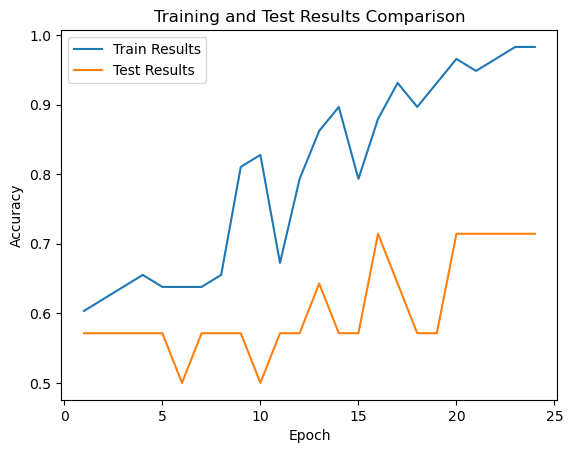

In [87]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_results) + 1))

plt.plot(epochs, train_results, label='Train Results')
plt.plot(epochs, test_results, label='Test Results')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Results Comparison')
plt.legend()

plt.show()

### Leave one out

In [64]:
random.shuffle(data_list)

In [71]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [75]:
train_results = []
test_results = []

for idx in range(len(data_list)):
    train_dataset = data_list[:]
    test_dataset = [train_dataset.pop(idx)]
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = GCN(hidden_channels=64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    
    print(f"Train dataset size = {len(train_dataset)}, Test dataset size = {len(test_dataset)}, Idx = {idx}")

    print(f'-----------------IDX: {idx}-------------------')
    for epoch in range(1, 21):
        train()
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    train_results.append(train_acc)
    test_results.append(test_acc)

Train dataset size = 71, Test dataset size = 1, Idx = 0
-----------------IDX: 0-------------------
Epoch: 001, Train Acc: 0.6056, Test Acc: 0.0000
Epoch: 002, Train Acc: 0.6479, Test Acc: 0.0000
Epoch: 003, Train Acc: 0.6056, Test Acc: 0.0000
Epoch: 004, Train Acc: 0.6479, Test Acc: 0.0000
Epoch: 005, Train Acc: 0.6620, Test Acc: 0.0000
Epoch: 006, Train Acc: 0.6761, Test Acc: 0.0000
Epoch: 007, Train Acc: 0.7324, Test Acc: 0.0000
Epoch: 008, Train Acc: 0.6901, Test Acc: 0.0000
Epoch: 009, Train Acc: 0.7606, Test Acc: 0.0000
Epoch: 010, Train Acc: 0.8169, Test Acc: 0.0000
Epoch: 011, Train Acc: 0.7324, Test Acc: 0.0000
Epoch: 012, Train Acc: 0.8169, Test Acc: 0.0000
Epoch: 013, Train Acc: 0.8451, Test Acc: 0.0000
Epoch: 014, Train Acc: 0.8451, Test Acc: 0.0000
Epoch: 015, Train Acc: 0.8732, Test Acc: 0.0000
Epoch: 016, Train Acc: 0.9155, Test Acc: 0.0000
Epoch: 017, Train Acc: 0.9014, Test Acc: 0.0000
Epoch: 018, Train Acc: 0.9155, Test Acc: 0.0000
Epoch: 019, Train Acc: 0.9296, Test A

In [76]:
mean_training_acc = np.mean(train_results)
mean_testing_acc = np.mean(test_results)
print(f"Average training accuracy = {mean_training_acc}, average testing accuracy = {mean_testing_acc}")

Average training accuracy = 0.9113849765258214, average testing accuracy = 0.5416666666666666


### Pick examples that are always misclassified